# Medium-range Global Weather Forecasting Based on GNN

## Overview

GraphCast is a data-driven global weather forecast model developed by researchers from DeepMind and Google. It provides medium-term forecasts of key global weather indicators with a resolution of 0.25°. Equivalent to a spatial resolution of approximately 25 km x 25 km near the equator and a global grid of 721 x 1440 pixels in size. Compared with the previous ML-based weather forecast model, this model improves the accuarcy to 99.2% of the 252 targets.

This tutorial introduces the research background and technical path of GraphCast, and shows how to train and fast infer the model through MindEarth. More information can be found in [paper](https://arxiv.org/abs/2212.12794).

## GraphCast

In order to achieve high resolution prediction, GraphCast uses GNNs as backbone network in an "encode-process-decode" model. The GNN-based leanred network architecture is designed for complex physical dynamics of input, uses message-passing allowing arbitrary patterns of spatial interactions over any range. The model uses the multi-mesh representation allows long-range interactions within few steps.

The following figure shows the GraphCast network architecture.

![GraphCast model](images/GraphCast.jpg)

1. Input Weather state: The high-resolution latitude-longitude-pressure-level grid represented surfarce variables(yellow layers) and atmospheric variables(blue layers) in Figure (a).

2. Predicting the next state: GraphCast model predicted next step weather state by the current time state and previous time state. The format is as follows:

$$
\hat X^{t-1} = GraphCast(X^t, X^{t-1})
$$

3. Rolling out a forecast: GraphCast iteratively generates a T-step forecast. The format is as follows:

$$
\hat X^{t+1:t+T} = (GraphCast(X^t, X^{t-1}), GraphCast(X^{t+1}, X^{t}), ..., GraphCast(\hat X^{t+T-1}, \hat X^{t+T-2}))
$$

4. Encoder-Processor-Decoder: The GraphCast model contains encoder layer, processor layer and decoder layer.

    In the encoder layer, all input features were embedded into latent space using multi-layer perceptrons(MLP). The model used message passing step to transfer the original latitude-longitude grid to the multi-mesh.

    In the processor layer, a 16-layer deep GNN to learn the long-range edges on the multi-mesh that contain all multi-mesh edges. For each GNN layer, the adjacent nodes were used to update mesh edges. Then, it updates mesh nodes by aggregating information from all edges connected that node. Then, added a residual connection to updated edges and nodes.

    In the decoder layer, it mapped the multi-mesh information back to the original latitude-longitude grid, which updated grid to mesh edges by aggregating information. Then, added a residual connection to updated edges and nodes.

5. Simultaneous multi-mesh message-passing: The key of GraphCast is the muti-mesh representation. The multi-mesh is a set of R-refined icosahedral mesh $M^R$.

## Technology Path

MindEarth solves the problem as follows:

1. Model Construction.
2. Loss Function.
3. Model Training.
4. Model Evaluation and Visualization.

Download the training and test dataset: [graphcast/dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/) .

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from mindspore import set_seed
from mindspore import context, Model
from mindspore.train.loss_scale_manager import DynamicLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net

The following `src` can be downloaded in [graphcast/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/graphcast/src).

In [2]:
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data, make_dir
from mindearth.module import Trainer
from mindearth.data import Dataset, Era5Data
from mindearth.cell import GraphCastNet

from src import get_coe, GridMeshInfo
from src import EvaluateCallBack, LossNet, CustomWithLossCell, InferenceModule

In [3]:
set_seed(0)
np.random.seed(0)
random.seed(0)

You can get parameters of model, data and optimizer from [config](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/graphcast/GraphCast.yaml).

In [4]:
# set context for training: using graph mode for high performance training with Ascend acceleration
config = load_yaml_config("GraphCast.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

## Model Construction


The initialization of the model include:

1. Load the mesh and grid information.

2. Load the per-variable-level inverse variance of time differences.

In [5]:
config['train']['amp_level'] = 'O2'
config['train']['distribute'] = False
config['model']['latent_dims'] = 512
config['model']['processing_steps'] = 16
config['model']['recompute'] = False
config['model']['data_sink'] = True

config['data']['num_workers'] = 1
config['data']['mesh_level'] = 4
config['data']['grid_resolution'] = 1.4
config['data']['h_size'], config['data']['w_size'] = 128, 256

config['optimizer']['epochs'] = 100
config['optimizer']['finetune_epochs'] = 1
config['optimizer']['initial_lr'] = 0.00025

config['summary']["eval_interval"] = 10
config['summary']['plt_key_info'] = False
config['summary']["summary_dir"] = './summary'
make_dir(os.path.join(config['summary']["summary_dir"], "image"))
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [6]:
data_params = config["data"]
model_params = config["model"]
grid_mesh_info = GridMeshInfo(data_params)
model = GraphCastNet(vg_in_channels=data_params['feature_dims'] * data_params['t_in'],
                     vg_out_channels=data_params['feature_dims'],
                     vm_in_channels=data_params['vm_in_channels'],
                     em_in_channels=data_params['em_in_channels'],
                     eg2m_in_channels=data_params['eg2m_in_channels'],
                     em2g_in_channels=data_params['em2g_in_channels'],
                     latent_dims=model_params['latent_dims'],
                     processing_steps=model_params['processing_steps'],
                     g2m_src_idx=grid_mesh_info.g2m_src_idx,
                     g2m_dst_idx=grid_mesh_info.g2m_dst_idx,
                     m2m_src_idx=grid_mesh_info.m2m_src_idx,
                     m2m_dst_idx=grid_mesh_info.m2m_dst_idx,
                     m2g_src_idx=grid_mesh_info.m2g_src_idx,
                     m2g_dst_idx=grid_mesh_info.m2g_dst_idx,
                     mesh_node_feats=grid_mesh_info.mesh_node_feats,
                     mesh_edge_feats=grid_mesh_info.mesh_edge_feats,
                     g2m_edge_feats=grid_mesh_info.g2m_edge_feats,
                     m2g_edge_feats=grid_mesh_info.m2g_edge_feats,
                     per_variable_level_mean=grid_mesh_info.sj_mean,
                     per_variable_level_std=grid_mesh_info.sj_std,
                     recompute=model_params['recompute'])

## Loss Function

GraphCast uses custom mean squared error for model training. The function was:

![Loss function](images/loss.png)

In [7]:
sj_std, wj, ai = get_coe(config)
loss_fn = LossNet(ai, wj, sj_std, config['data']['feature_dims'])
loss_cell = CustomWithLossCell(backbone=model, loss_fn=loss_fn, data_params=config['data'])

## Model Training

In this tutorial, we inherite the Trainer and override the `_get_solver` member function to build custom loss function, and override `_get_callback` member function to perform inference on the test dataset during the training process.

MindEarth provide training and inference interface for model training with `MindSpore` version >= 1.8.1.

In [8]:
class GraphCastTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self._get_dataset()
        self.pred_cb = self._get_callback()
        self.solver = self._get_solver()

    def _get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(network=self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params['amp_level'],
                       )
        return solver

    def _get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


In [9]:
trainer = GraphCastTrainer(config, model, loss_cell, logger)
trainer.train()

2023-08-18 08:31:11,242 - pretrain.py[line:211] - INFO: steps_per_epoch: 403


epoch: 1 step: 403, loss is 0.003921998
Train epoch time: 77295.547 ms, per step time: 191.800 ms
epoch: 2 step: 403, loss is 0.003456553
Train epoch time: 48287.290 ms, per step time: 119.820 ms
epoch: 3 step: 403, loss is 0.0028922241
Train epoch time: 48298.168 ms, per step time: 119.847 ms
epoch: 4 step: 403, loss is 0.0028646633
Train epoch time: 48293.240 ms, per step time: 119.834 ms
epoch: 5 step: 403, loss is 0.00251652
Train epoch time: 48303.110 ms, per step time: 119.859 ms
epoch: 6 step: 403, loss is 0.0024913677
Train epoch time: 48301.862 ms, per step time: 119.856 ms
epoch: 7 step: 403, loss is 0.0023838188
Train epoch time: 48326.265 ms, per step time: 119.916 ms
epoch: 8 step: 403, loss is 0.0021626246
Train epoch time: 48325.142 ms, per step time: 119.914 ms
epoch: 9 step: 403, loss is 0.002123243
Train epoch time: 48321.305 ms, per step time: 119.904 ms
epoch: 10 step: 403, loss is 0.002461584
Train epoch time: 49511.084 ms, per step time: 122.856 ms


2023-08-18 08:39:45,287 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 08:40:41,617 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 08:40:41,621 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 08:40:41,622 - forecast.py[line:183] - INFO:  RMSE of Z500: 99.63094225503905, T2m: 1.7807282244821678, T850: 1.1389199313716583, U10: 1.3300655484052706
2023-08-18 08:40:41,623 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9995030164718628, T2m: 0.9949086904525757, T850: 0.9965617656707764, U10: 0.9709641933441162
2023-08-18 08:40:41,624 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 08:40:41,625 - forecast.py[line:183] - INFO:  RMSE of Z500: 846.2669541832905, T2m: 5.095069601461138, T850: 4.291456435667611, U10: 5.033789250954006
2023-08-18 08:40:41,627 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9656049013137817, T2m: 0.9600029587745667, T850: 0.9581822752952576, U10: 0.59237

......

epoch: 91 step: 403, loss is 0.00090005953
Train epoch time: 48299.581 ms, per step time: 119.850 ms
epoch: 92 step: 403, loss is 0.0009103894
Train epoch time: 48302.468 ms, per step time: 119.857 ms
epoch: 93 step: 403, loss is 0.00090527127
Train epoch time: 48296.220 ms, per step time: 119.842 ms
epoch: 94 step: 403, loss is 0.0009113429
Train epoch time: 48314.221 ms, per step time: 119.886 ms
epoch: 95 step: 403, loss is 0.0008906296
Train epoch time: 48332.578 ms, per step time: 119.932 ms
epoch: 96 step: 403, loss is 0.0009023069
Train epoch time: 48344.677 ms, per step time: 119.962 ms
epoch: 97 step: 403, loss is 0.00088527385
Train epoch time: 48319.437 ms, per step time: 119.899 ms
epoch: 98 step: 403, loss is 0.00087669905
Train epoch time: 48319.398 ms, per step time: 119.899 ms
epoch: 99 step: 403, loss is 0.00088527397
Train epoch time: 48305.233 ms, per step time: 119.864 ms
epoch: 100 step: 403, loss is 0.00093020557
Train epoch time: 49486.354 ms, per step time: 122.

2023-08-18 09:57:55,343 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 09:58:29,557 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 09:58:29,562 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 09:58:29,563 - forecast.py[line:183] - INFO:  RMSE of Z500: 71.52867536392974, T2m: 1.1144296184615285, T850: 0.950450431058116, U10: 1.2159413055648252
2023-08-18 09:58:29,564 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9997411966323853, T2m: 0.9980063438415527, T850: 0.9975705146789551, U10: 0.9757701754570007
2023-08-18 09:58:29,566 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 09:58:29,567 - forecast.py[line:183] - INFO:  RMSE of Z500: 564.955831718179, T2m: 3.2896556874900664, T850: 2.986913832820727, U10: 3.7879051445350314
2023-08-18 09:58:29,568 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9842368364334106, T2m: 0.9827487468719482, T850: 0.9765684008598328, U10: 0.77273

## Model Evaluation and Visualization

After training, we use the 100th checkpoint for inference. The visualization of predictions, ground truth and their error is shown below.

In [12]:
params = load_checkpoint('./summary/ckpt/step_1/GraphCast-100_403.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger)

In [13]:
test_dataset_generator = Era5Data(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']

In [14]:
labels = labels[..., 0, :, :]
labels = labels.transpose(0, 2, 1)
labels = labels.reshape(labels.shape[0], labels.shape[1], data_params["h_size"], data_params["w_size"]).asnumpy()

pred = inference_module.forecast(inputs)
pred = pred[0].transpose(1, 0)
pred = pred.reshape(pred.shape[0], data_params["h_size"], data_params["w_size"]).asnumpy()
pred = np.expand_dims(pred, axis=0)

In [15]:
def plt_key_info_comparison(pred, label, root_dir):
    """ Visualize the comparison of forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))

    plt.figure(num='e_imshow', figsize=(100, 50), dpi=100)

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error')  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error')  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True)  # T2M

    plt.savefig(f'key_info_comparison.png', bbox_inches='tight')
    plt.show()

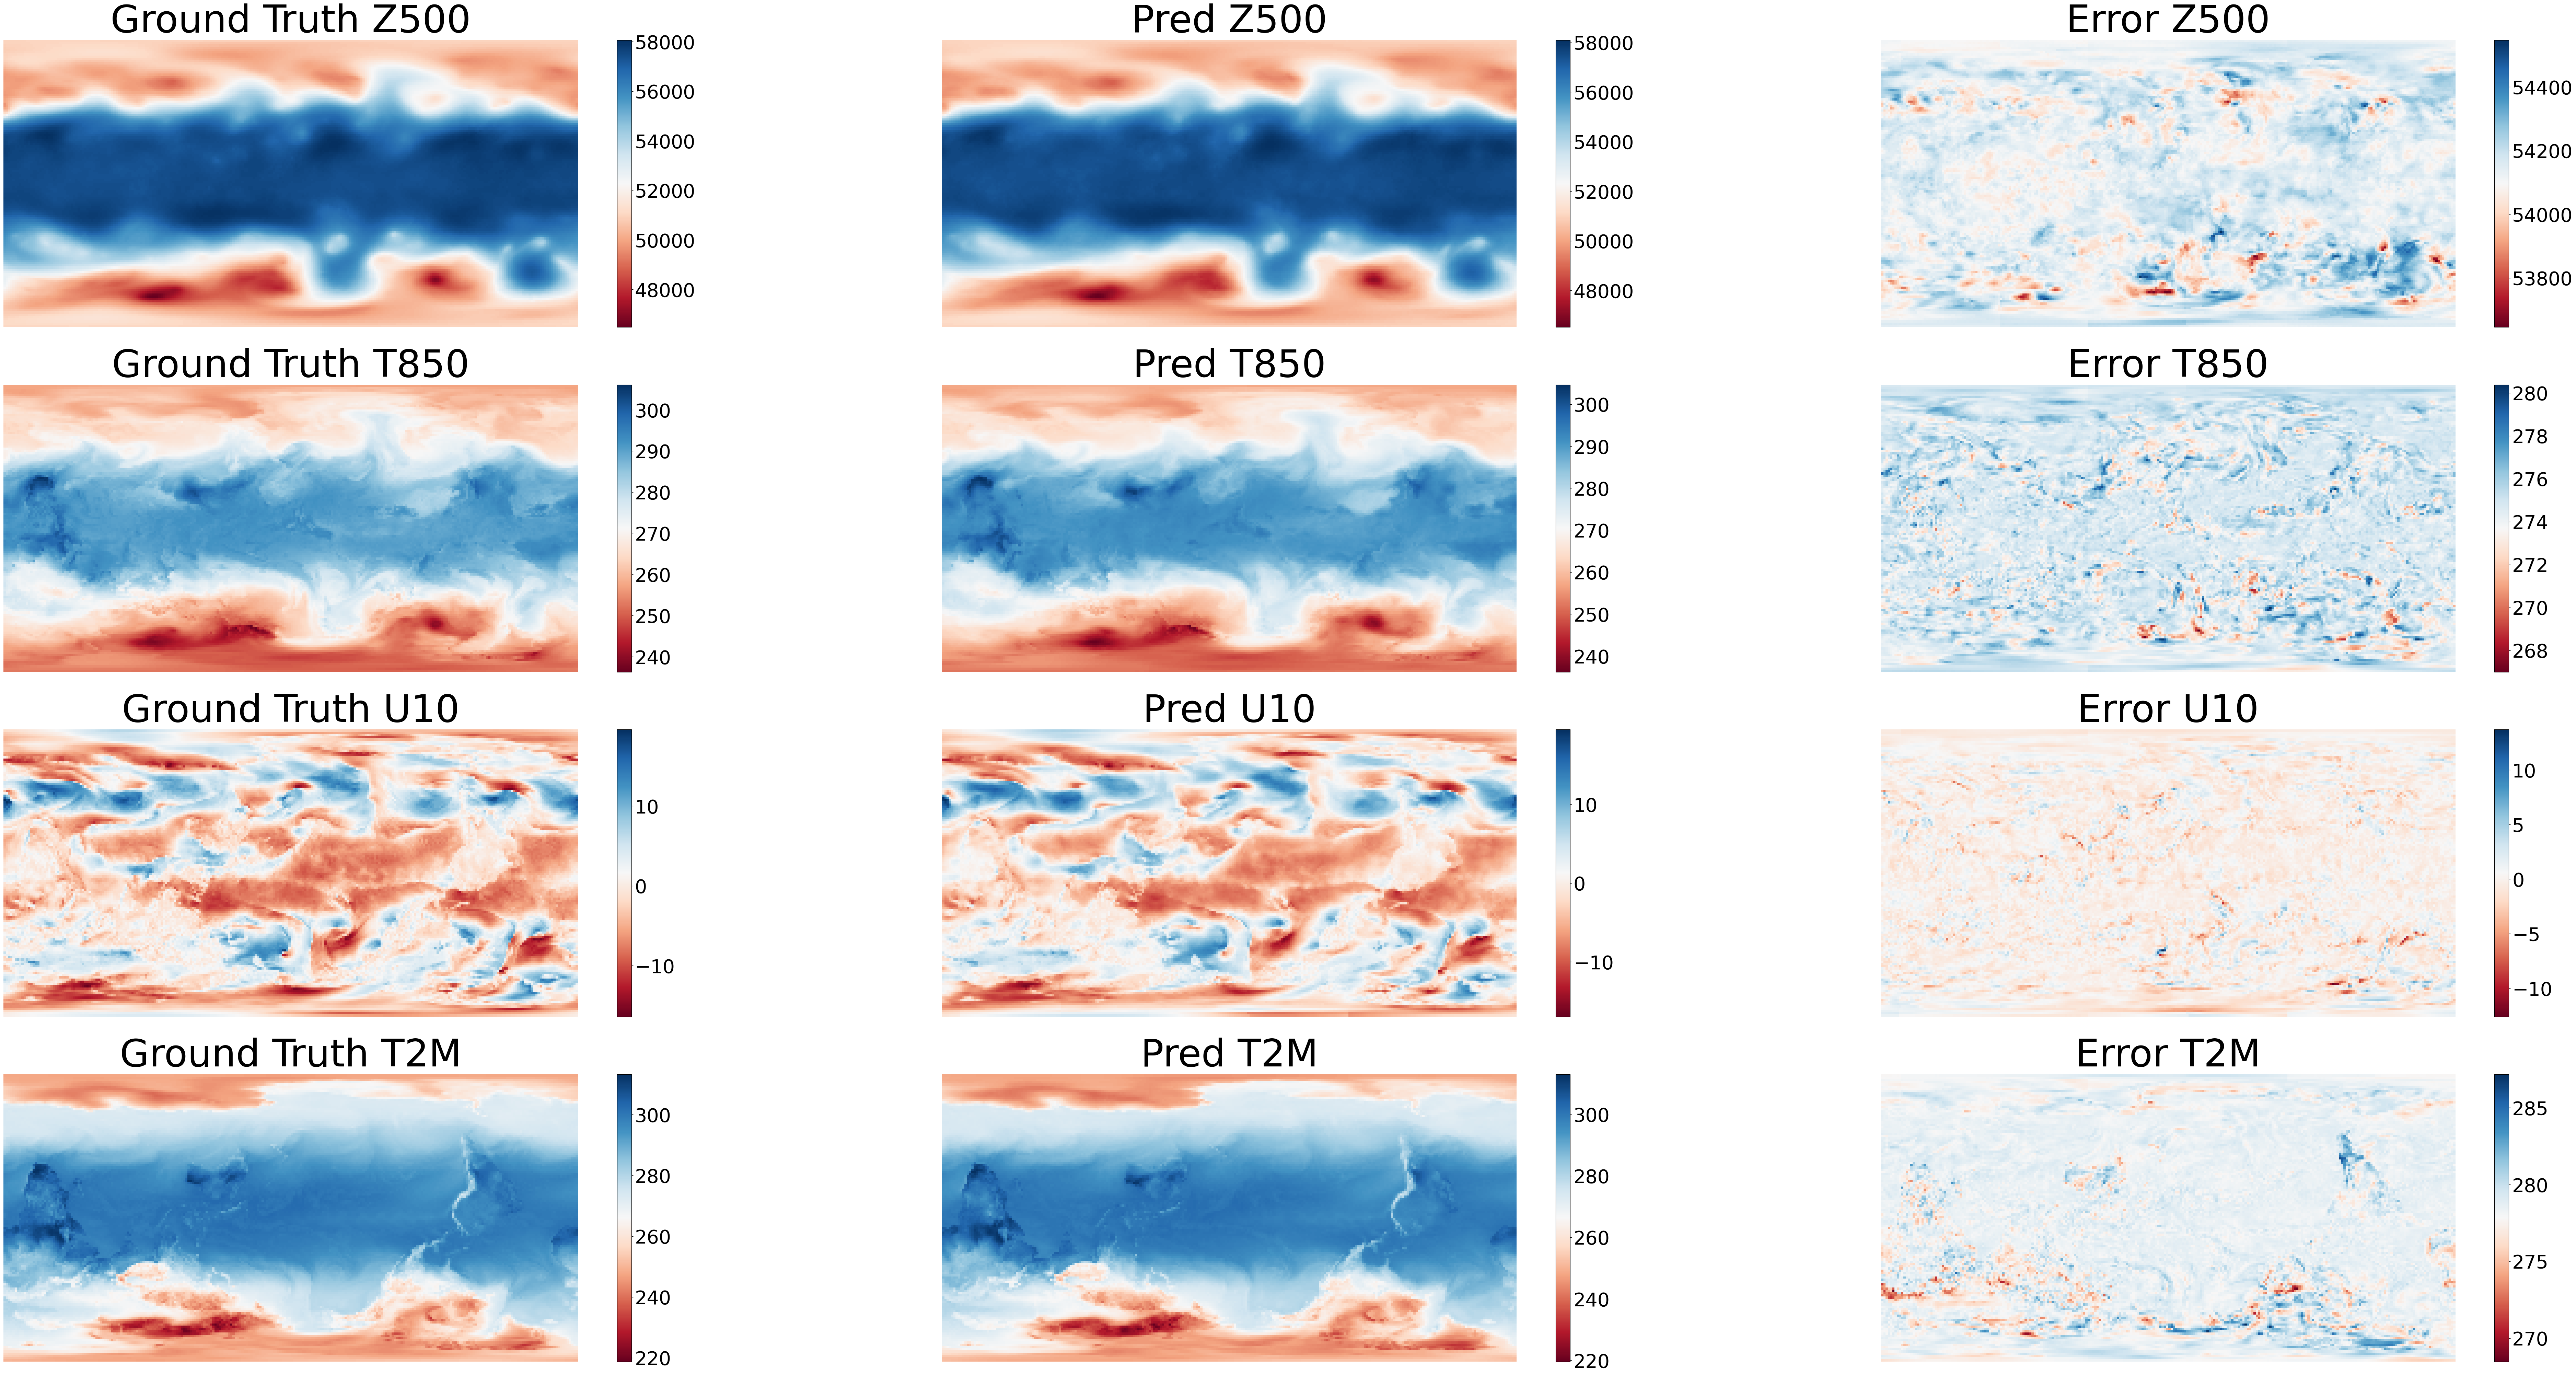

In [16]:
plt_key_info_comparison(pred, labels, data_params['root_dir'])